## Tuturial 2: Exploring the Data

As specified in the spec, we examine some statistics of the datasets downloaded in **Tutorial 1**. In particular:
* Changes in price over time
* Returns over time 

In [204]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [185]:
# get all path names
import os
dir_name = "./data/"
file_names = os.listdir(dir_name)
# filter hidden files 
file_names = [name for name in file_names if not name.startswith(".")]
TICKERS = [None] * len(file_names)
start_date, end_date = None, None
# extract tickers
for k in range(len(file_names)):
    tmp = file_names[k].split("_")
    tk = tmp[0]
    if start_date is None:
        start_date = tmp[1]
    if end_date is None:
        end_date = tmp[-1].split(".")[0]
    TICKERS[k] = tk
print("> Date range = {} TO {}".format(start_date, end_date))
print("> Tickers = {}".format(TICKERS))

> Date range = 2015-04-30 TO 2024-04-30
> Tickers = ['IBM', 'INTC', 'TSLA', 'QCOM', 'NVDA', 'META', 'AVGO', 'TCEHY', 'ORCL', 'AMZN', 'GOOG', 'MSFT', 'AAPL', 'TSM', 'CRM', 'BABA', 'CSCO', 'ADBE']


### Daily price changes

In [186]:
n = len(TICKERS)
daily_changes = dict()
for k in range(n):
    tk = TICKERS[k]
    fname = file_names[k]
    # load data
    tmp = dir_name + fname
    data = pd.read_csv(tmp)
    assert not data.isnull().values.any()
    # use adjusted close 
    date = data["Date"]
    price = data["Adj Close"]
    # compute price changes
    daily_changes[tk] = (
        date, price.diff(1)
    )

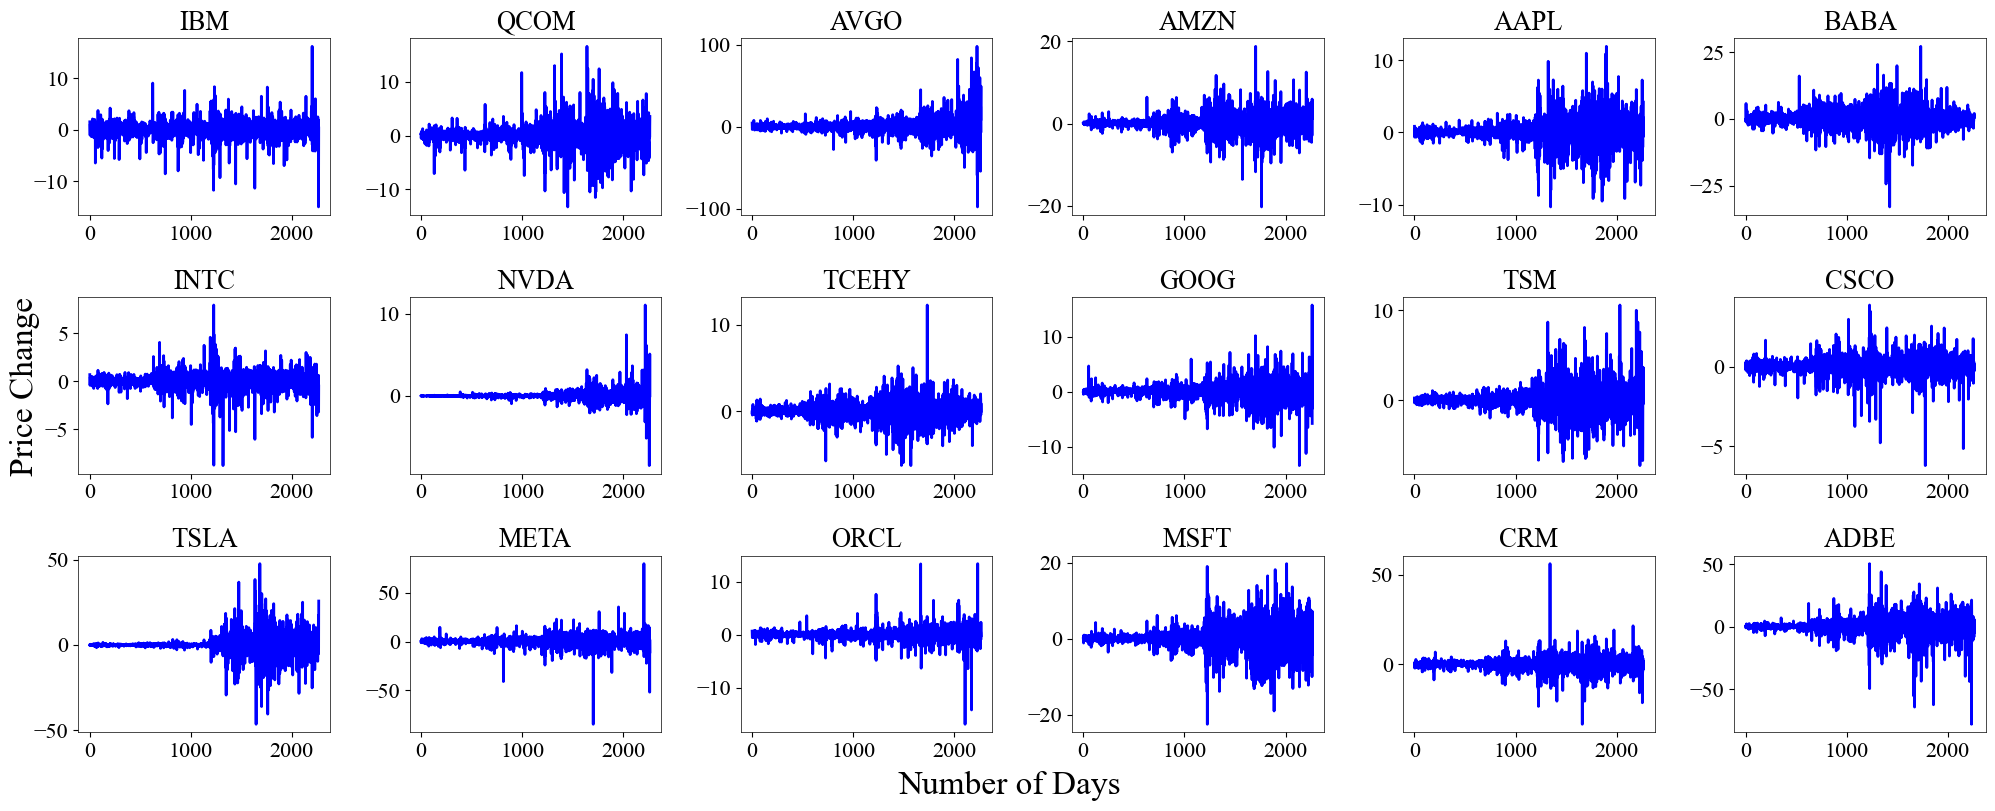

In [187]:
# plot all daily price changes 
import matplotlib as mpl
# global plot parameters 
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["axes.edgecolor"] = "black"
import matplotlib.pyplot as plt
font = {'size'   : 16}

mpl.rc('font', **font)

# subplot config
nrow = 3
ncol = 6
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))
for k in range(n):
    r, c = k % nrow, k // nrow
    tk = TICKERS[k]
    date = daily_changes[tk][0]
    changes = daily_changes[tk][1]
    ax[r, c].plot(
        changes, lw=2.0, color="blue"
    )
    ax[r, c].patch.set_linewidth(1);
    ax[r, c].set_title(tk)
fig.tight_layout()
fig.set_edgecolor("k");
fig.text(0.5, -0.01, 'Number of Days', ha='center', fontsize=24);
fig.text(0.0, 0.5, 'Price Change', va='center', rotation='vertical', fontsize=24);
# save plot
plt.savefig("./img/price_changes.png", dpi=200, bbox_inches='tight');

We proceed to show statistics of the daily price changes in the form of boxplots.

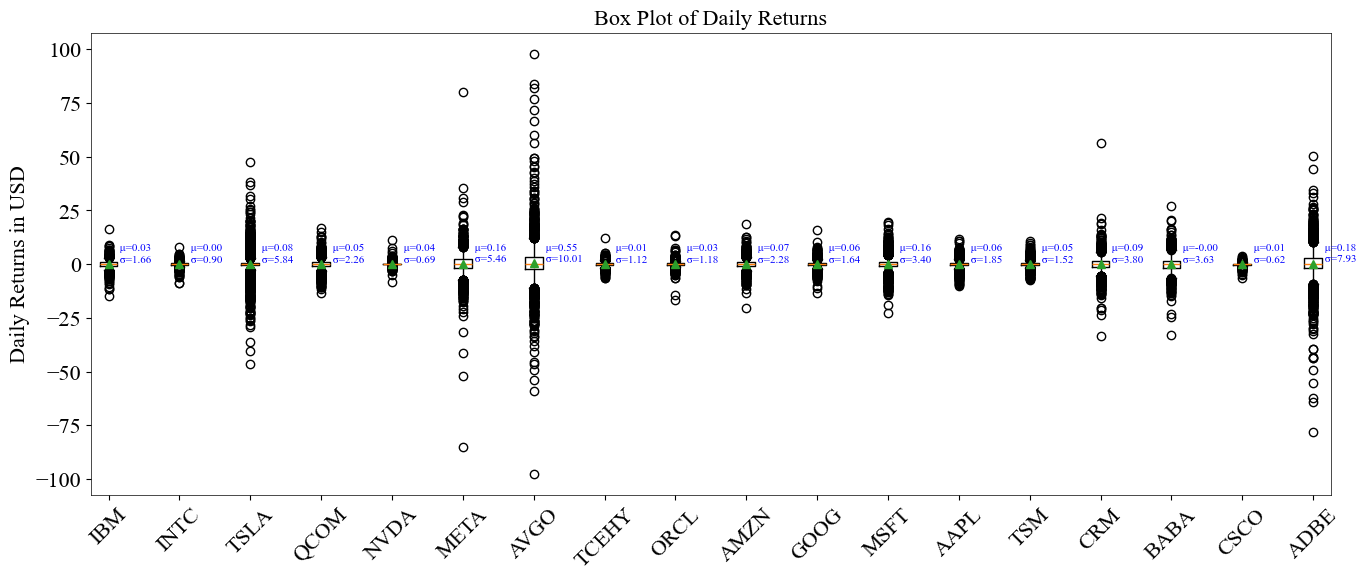

In [188]:
# reformat data 
all_invms = list(daily_changes.keys())
daily_changes_reformatted = {} 
for invm in all_invms:
    daily_changes_reformatted[invm] = daily_changes[invm][1].dropna()
daily_changes_reformatted = pd.DataFrame(daily_changes_reformatted)

# compute mean and std
tmp = daily_changes_reformatted.values
m1 = np.mean(daily_changes_reformatted.values, axis=0)
st1 = np.std(daily_changes_reformatted.values, axis=0)


n, k = daily_changes_reformatted.shape
# for plotting setup
positions = np.arange(k) * 2
plt.figure(2, figsize=(16, 6));
bp = plt.boxplot(daily_changes_reformatted, positions=positions, showmeans=True)
# display values 
for i, line in enumerate(bp["medians"]):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    plt.annotate(text, xy=(x, y), fontsize=8, color="blue", 
                 horizontalalignment='left', verticalalignment='bottom');


plt.title("Box Plot of Daily Returns", fontsize=16);
plt.xticks(positions, all_invms, rotation=45);
plt.ylabel("Daily Returns in USD")
# save plot
plt.savefig("./img/price_changes2.png", dpi=200, bbox_inches='tight');

Before taking a closer look at their return distributions, we need to first verify that we can indeed break the ordering in time - namely, we need to check to ensure that the return data is stationary. 

We do so by applying the [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) and [KPSS test](https://en.wikipedia.org/wiki/KPSS_test). 

In [189]:
print(TICKERS)

['IBM', 'INTC', 'TSLA', 'QCOM', 'NVDA', 'META', 'AVGO', 'TCEHY', 'ORCL', 'AMZN', 'GOOG', 'MSFT', 'AAPL', 'TSM', 'CRM', 'BABA', 'CSCO', 'ADBE']


In [190]:
# compute log series using adjusted close
n = len(TICKERS)
pct_return = {}
for k in range(n):
    tk = TICKERS[k]
    fname = file_names[k]
    # load data
    tmp = dir_name + "/" + fname
    data = pd.read_csv(tmp)
    assert not data.isnull().values.any()
    # use adjusted close 
    date = data["Date"]
    price = data["Adj Close"]
    ret = np.log(price) - np.log(price.shift(1))
    # compute price changes
    pct_return[tk] = (
        date, ret
    )

In [191]:
from statsmodels.tsa.stattools import adfuller, kpss
# run augmented Dickey-Fuller test
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag=None)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

def kpss_test(timeseries):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return kpss_output

We test stationarity for all the stock returns. By default, the critical value for the one-sided test is 0.05. The null hypothesis of the augmented Dickey-Fuller test is that the time series contains a unit root. 

In [192]:
test_results = {}
for k in range(n):
    tk = TICKERS[k]
    # run Dickey-Fuller test on return series
    res = adf_test(
        pct_return[tk][1].dropna()
    )
    test_stat = res["Test Statistic"]
    # 0.05 critical value
    crit_val = res["Critical Value (5%)"]
    if test_stat < crit_val:
        # reject the null hypothesis / stationary
        test_results[tk] = (test_stat, crit_val, 1)
    else:
        test_results[tk] = (test_stat, crit_val, 0)

In [193]:
test_results

{'IBM': (-10.03614053836081, -2.8628334711844436, 1),
 'INTC': (-9.556992446890543, -2.8628334711844436, 1),
 'TSLA': (-9.419554840577966, -2.8628334711844436, 1),
 'QCOM': (-10.142452445912426, -2.8628334711844436, 1),
 'NVDA': (-8.385826990538135, -2.8628334711844436, 1),
 'META': (-7.844550374798519, -2.8628334711844436, 1),
 'AVGO': (-9.934208394433623, -2.8628334711844436, 1),
 'TCEHY': (-8.998132016982813, -2.8628334711844436, 1),
 'ORCL': (-10.29289638735776, -2.8628334711844436, 1),
 'AMZN': (-9.07108476071921, -2.8628334711844436, 1),
 'GOOG': (-9.816091294661161, -2.8628334711844436, 1),
 'MSFT': (-10.475371374330113, -2.8628334711844436, 1),
 'AAPL': (-8.744152694748012, -2.8628334711844436, 1),
 'TSM': (-9.435237967179244, -2.8628334711844436, 1),
 'CRM': (-9.127858278200891, -2.8628334711844436, 1),
 'BABA': (-9.298584226978862, -2.8628334711844436, 1),
 'CSCO': (-9.747028460418669, -2.8628334711844436, 1),
 'ADBE': (-9.601720294305654, -2.8628334711844436, 1)}

The null hypothesis of KPSS test is that the returns are stationary around a deterministic trend against the alternative of a unit root

In [194]:
test_results = {}
for k in range(n):
    tk = TICKERS[k]
    # run Dickey-Fuller test on return series
    res = kpss_test(
        pct_return[tk][1].dropna()
    )
    test_stat = res["Test Statistic"]
    # 0.05 critical value
    crit_val = res["Critical Value (5%)"]
    if test_stat > crit_val:
        # reject the null hypothesis / stationary
        test_results[tk] = (test_stat, crit_val, 1)
    else:
        test_results[tk] = (test_stat, crit_val, 0)

/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/2921158844.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/2921158844.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/2921158844.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/29211

In [195]:
test_results

{'IBM': (0.10485530641141455, 0.463, 0),
 'INTC': (0.14801645721587864, 0.463, 0),
 'TSLA': (0.1555467578576643, 0.463, 0),
 'QCOM': (0.07935523206260572, 0.463, 0),
 'NVDA': (0.10389976481425008, 0.463, 0),
 'META': (0.08984394946764683, 0.463, 0),
 'AVGO': (0.07654415182699517, 0.463, 0),
 'TCEHY': (0.18881637210229804, 0.463, 0),
 'ORCL': (0.08428806266182291, 0.463, 0),
 'AMZN': (0.1845283227090766, 0.463, 0),
 'GOOG': (0.04299838525839467, 0.463, 0),
 'MSFT': (0.0538392748789058, 0.463, 0),
 'AAPL': (0.10006749213370628, 0.463, 0),
 'TSM': (0.06620343994083006, 0.463, 0),
 'CRM': (0.04966987379635595, 0.463, 0),
 'BABA': (0.2954516838593493, 0.463, 0),
 'CSCO': (0.07632317814068944, 0.463, 0),
 'ADBE': (0.22187368928982676, 0.463, 0)}

The price changes appear concentrated around zero. It would be more informative to plot the distribution of the returns. We do so below.

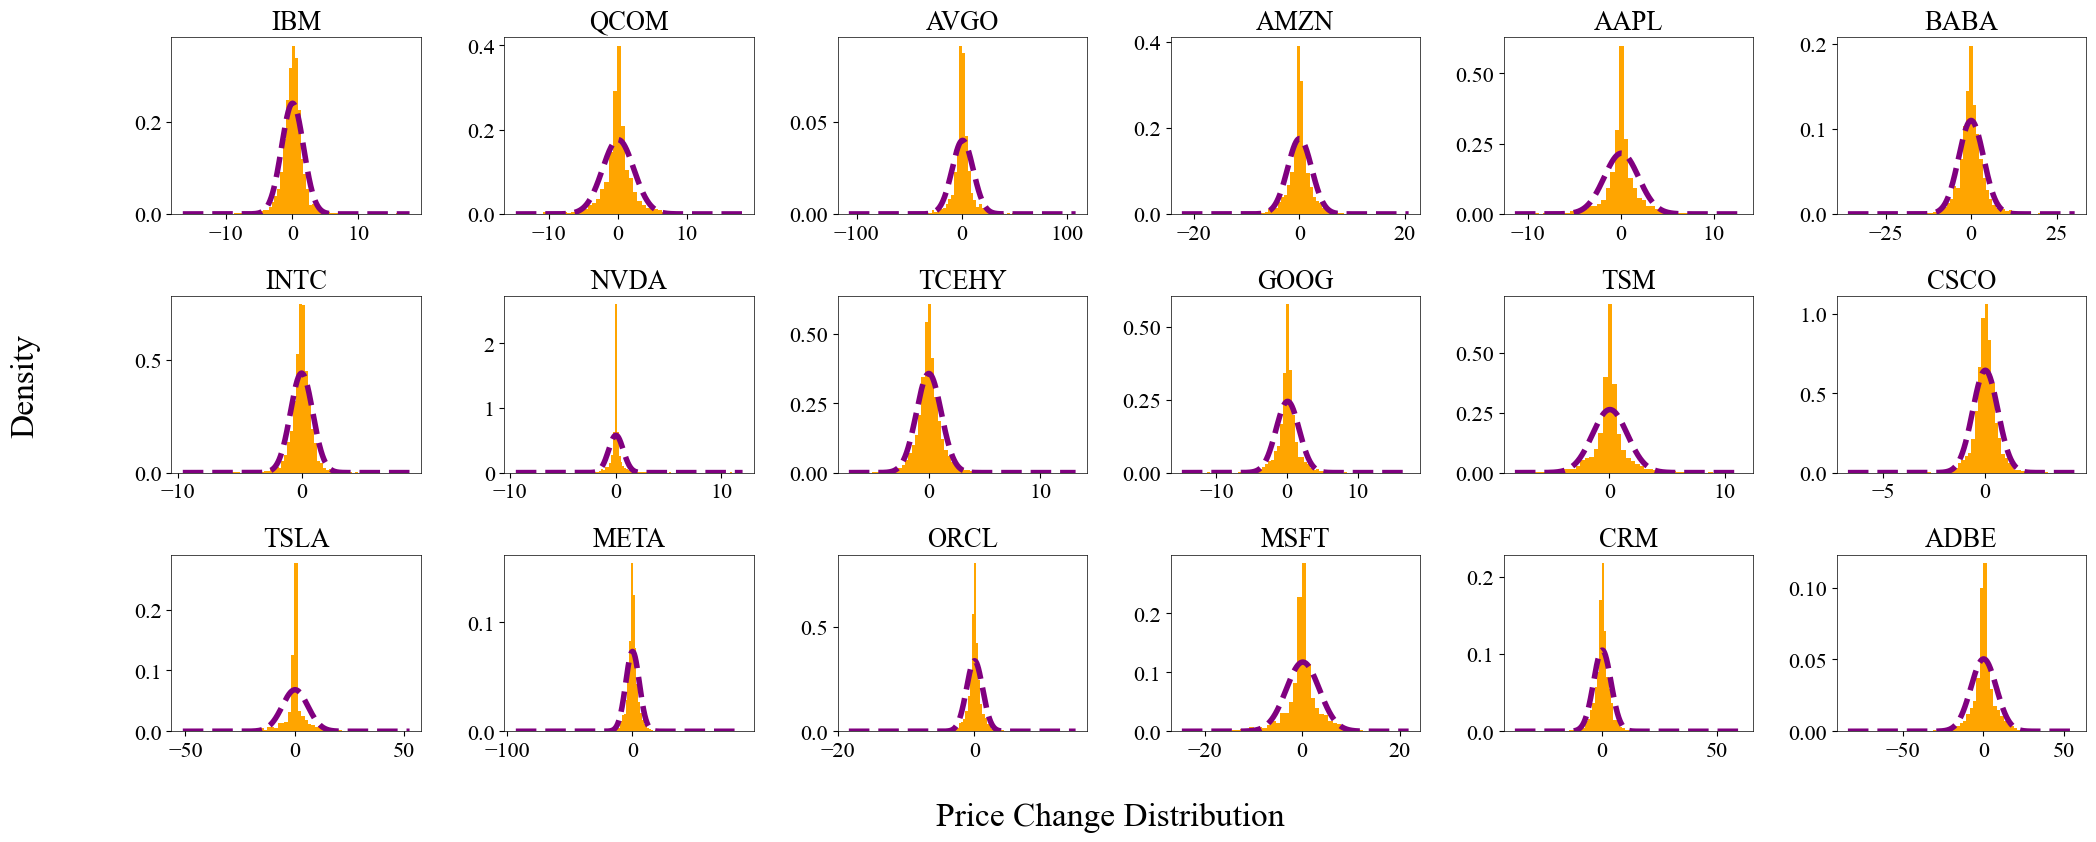

In [196]:
# subplot config
nrow = 3
ncol = 6
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))
for k in range(n):
    r, c = k % nrow, k // nrow
    tk = TICKERS[k]
    date = daily_changes[tk][0]
    changes = daily_changes[tk][1]
    ax[r, c].hist(
        changes, lw=2.0, color="orange", bins='scott', density=True
    )
    # get x axis
    xmin, xmax, _, _ = ax[r, c].axis()
    # plot best normal fit
    tmp = np.linspace(xmin, xmax, len(changes))
    # fitted loc and scale
    mu, sigma = scipy.stats.norm.fit(changes.dropna()) 
    ax[r, c].plot(
        tmp, scipy.stats.norm.pdf(tmp, mu, sigma), "--", color="purple", lw=4.0
    )
    ax[r, c].set_title(tk)
fig.tight_layout()
fig.text(0.5, -0.05, 'Price Change Distribution', ha='center', fontsize=24);
fig.text(-0.05, 0.5, 'Density', va='center', rotation='vertical', fontsize=24);



The price changes appear symmetrically distributed, with exceptions of skewedness (e.g. changes of NVDA appear right skewed, and those of CSCO appear left skewed). In order to be more precise, we conduct a Komogorov-Smirnov test for each price change series. The normal distributions being tested against have the same sample statistics (i.e. sample mean and sample standard deviation).

In [197]:
kstest_res = []
for k in range(n):
    tk = TICKERS[k]
    changes = daily_changes[tk][1].dropna()
    sample_mean, sample_std = np.mean(changes), np.std(changes)
    D, p = scipy.stats.kstest(changes, 'norm', args= (sample_mean, sample_std))
    test = 'Reject' if p < 0.05 else 'Not reject'
    kstest_res.append((tk, test))
kstest_res

[('IBM', 'Reject'),
 ('INTC', 'Reject'),
 ('TSLA', 'Reject'),
 ('QCOM', 'Reject'),
 ('NVDA', 'Reject'),
 ('META', 'Reject'),
 ('AVGO', 'Reject'),
 ('TCEHY', 'Reject'),
 ('ORCL', 'Reject'),
 ('AMZN', 'Reject'),
 ('GOOG', 'Reject'),
 ('MSFT', 'Reject'),
 ('AAPL', 'Reject'),
 ('TSM', 'Reject'),
 ('CRM', 'Reject'),
 ('BABA', 'Reject'),
 ('CSCO', 'Reject'),
 ('ADBE', 'Reject')]

All tests of normality are rejected. This means that normal distributions may not be apropriate models for the price changes. Our last exploration for the daily price changes series will be to compute sample skewness and kurtosis, before moving onto returns.

/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/726182056.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=TICKERS, rotation=60);
/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/726182056.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels=TICKERS, rotation=60);


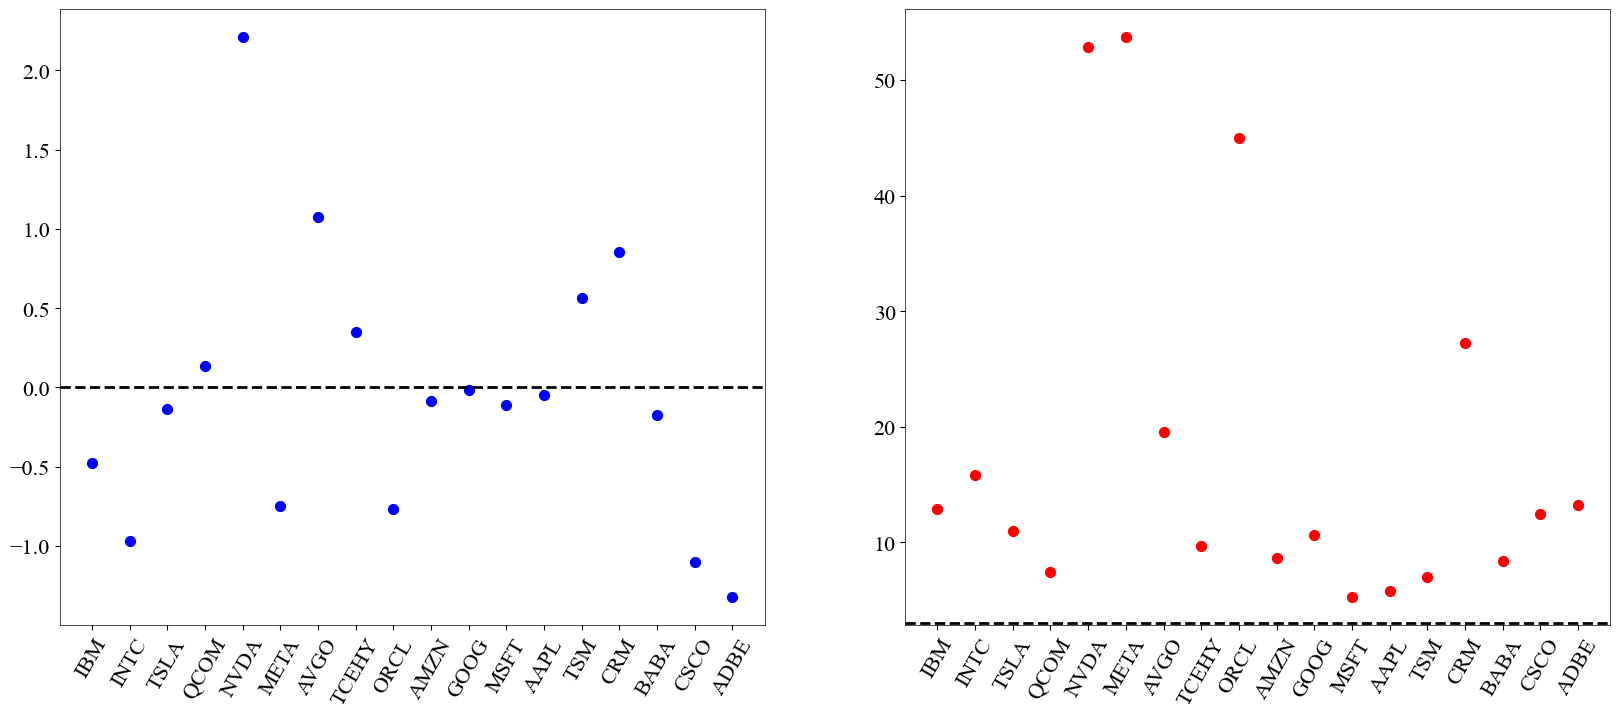

In [198]:
skew, kurt = np.zeros(n), np.zeros(n)
for k in range(n):
    tk = TICKERS[k]
    changes = daily_changes[tk][1].dropna()
    skew[k] = scipy.stats.skew(changes)
    kurt[k] = scipy.stats.kurtosis(changes)
fig, ax = plt.subplots(1, 2, figsize=(20, 8));
ax[0].scatter(TICKERS, skew, s=50, color="blue");
ax[0].set_xticklabels(labels=TICKERS, rotation=60);
ax[0].axhline(y=0.0, linestyle="--", lw=2.0, color='black');
ax[1].scatter(TICKERS, kurt, s=50, color='r');
ax[1].set_xticklabels(labels=TICKERS, rotation=60);
ax[1].axhline(y=3.0, linestyle="--", lw=2.0, color='black');

### Daily Returns

When the time horizon is short (daily in our case), we use simple returns. For long-time horizon price series, log returns are more appropriate in order to account for continuous compounding.

In [199]:
n = len(TICKERS)
simple_returns = dict()
for k in range(n):
    tk = TICKERS[k]
    fname = file_names[k]
    # load data
    tmp = dir_name + "/" + fname
    data = pd.read_csv(tmp)
    assert not data.isnull().values.any()
    # use adjusted close 
    date = data["Date"]
    price = data["Adj Close"]
    # compute price changes
    simple_returns[tk] = (
        date, np.log(price) - np.log(price.shift(1))
    )

We visualize the histogram of simple returns below, along with fitted normal densities.

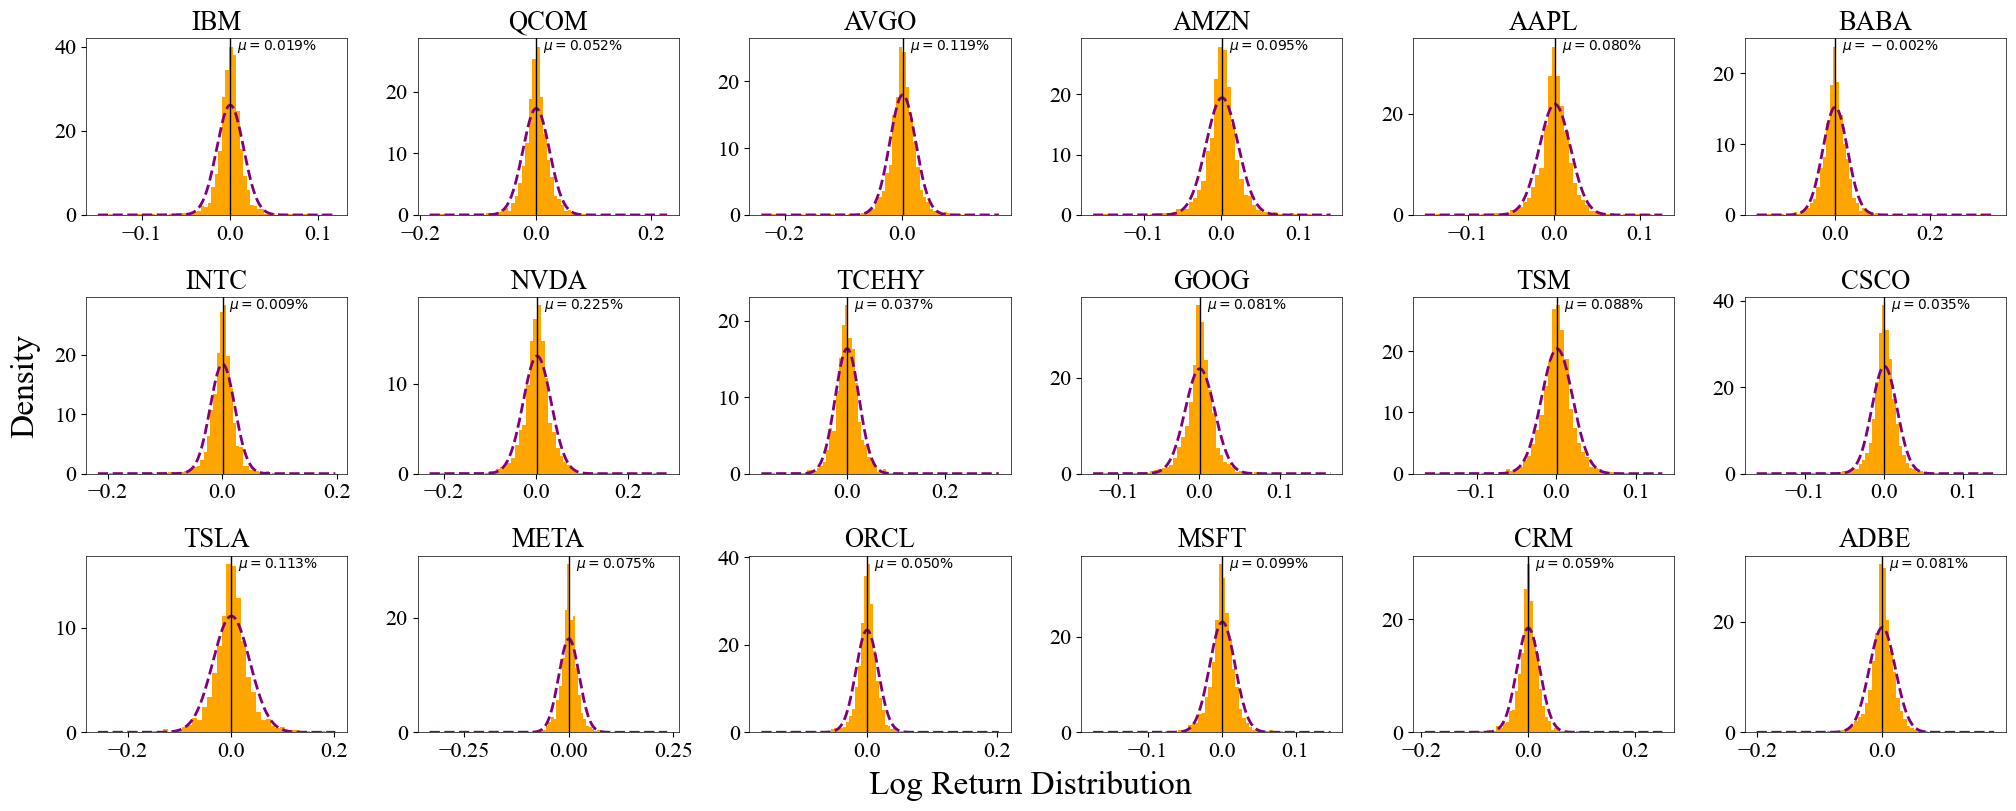

In [200]:
# subplot config
nrow = 3
ncol = 6
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))
for k in range(n):
    r, c = k % nrow, k // nrow
    tk = TICKERS[k]
    date = simple_returns[tk][0]
    changes = simple_returns[tk][1]
    ax[r, c].hist(
        changes, lw=2.0, color="orange", bins='scott', density=True
    )
    # get x axis
    xmin, xmax, _, _ = ax[r, c].axis()
    # plot best normal fit
    tmp = np.linspace(xmin, xmax, len(changes))
    # fitted loc and scale
    mu, sigma = scipy.stats.norm.fit(changes.dropna()) 
    ax[r, c].plot(
        tmp, scipy.stats.norm.pdf(tmp, mu, sigma), "--", color="purple", lw=2.0
    )
    ax[r, c].axvline(x=mu, color="black", lw=1.0)
    # annotate mean value
    ax[r, c].annotate(f'$\mu={mu*100:.3f}\%$', xy=(mu, ax[r, c].get_ylim()[1]), xytext=(5, 0),
                      textcoords='offset points', ha='left', va='top', color='black', fontsize=10)
    ax[r, c].set_title(tk)
fig.tight_layout()
fig.text(0.5, -0.01, 'Log Return Distribution', ha='center', fontsize=24);
fig.text(-0.01, 0.5, 'Density', va='center', rotation='vertical', fontsize=24);

# save plot
plt.savefig("./img/return_histogram.png", dpi=200, bbox_inches='tight');

The tails of the returns do not seem well-matched by normal distributions. We proceed with this line of investigation by using Q-Q plots. 

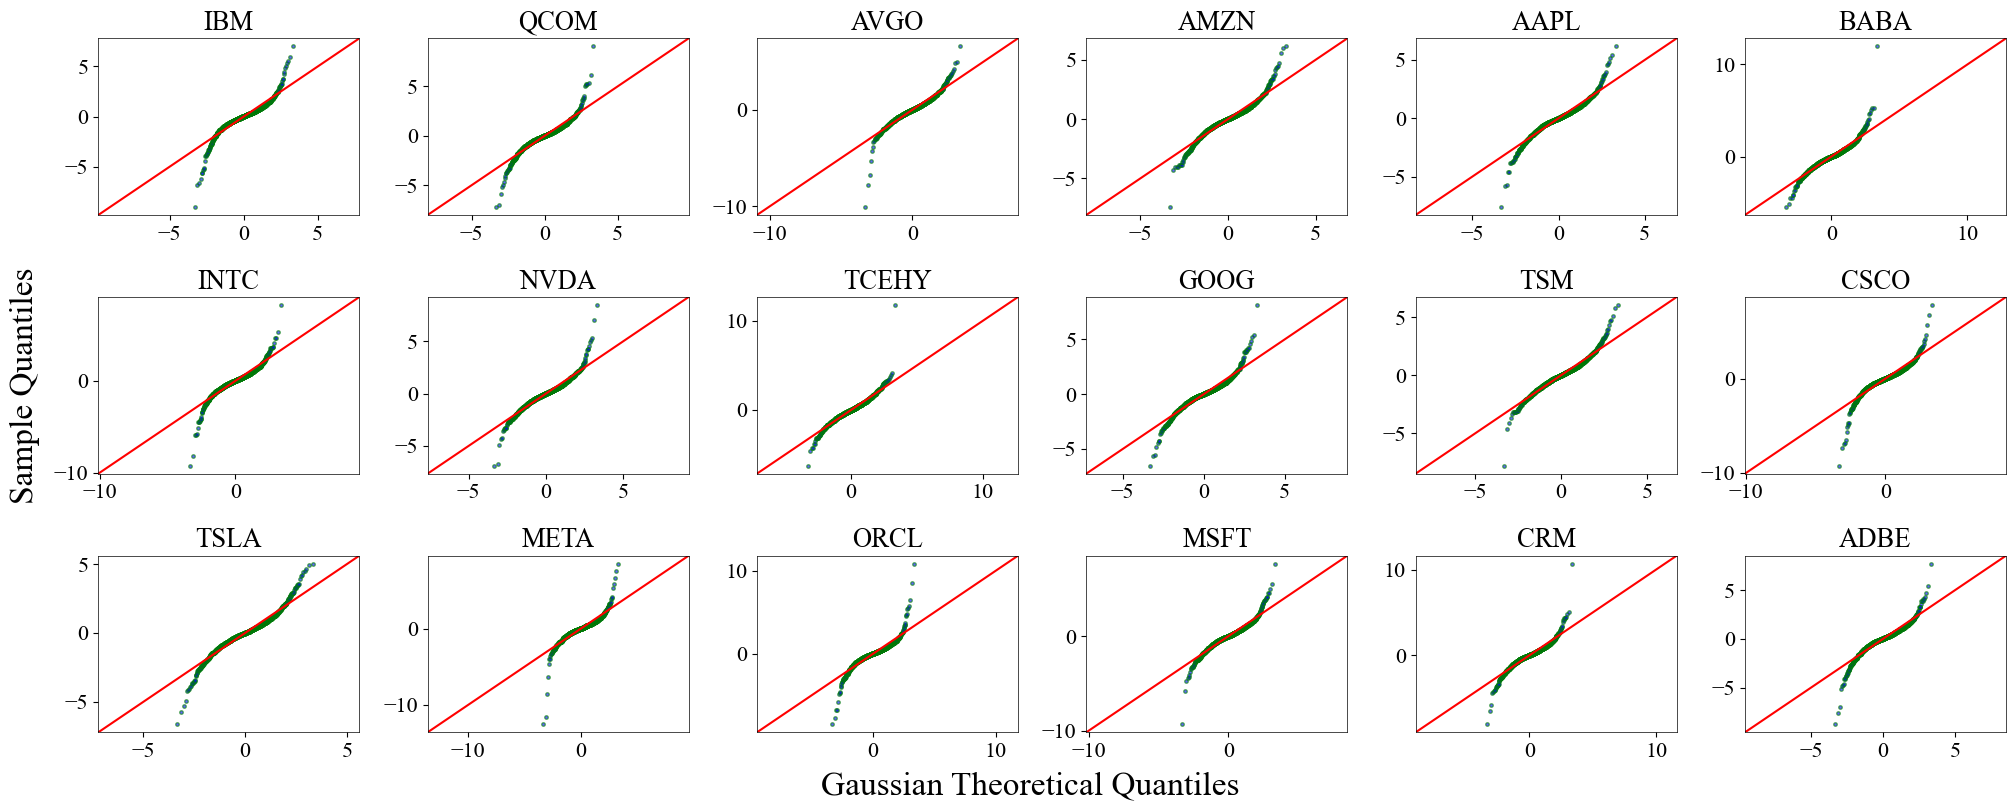

In [201]:
import statsmodels.api as sm

# subplot config
# Subplot configuration
nrow = 3
ncol = 6
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))
for k in range(n):
    r, c = k % nrow, k // nrow
    tk = TICKERS[k]
    date = simple_returns[tk][0]
    changes = simple_returns[tk][1].dropna()
    
    # Q-Q plot
    pp = sm.ProbPlot(changes, fit=True)
    qq = pp.qqplot(marker='.', ax=ax[r, c], markerfacecolor='blue', markeredgecolor='green', 
                   alpha=0.6, markersize=5)
    
    
    # Turn off x and y labels
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')
    
    ax[r, c].set_title(tk)

for ax in qq.axes:
    sm.qqline(ax, line='45', fmt='r--');
fig.tight_layout();
fig.text(0.5, -0.01, 'Gaussian Theoretical Quantiles', ha='center', fontsize=24);
fig.text(-0.01, 0.5, 'Sample Quantiles', va='center', rotation='vertical', fontsize=24);
plt.show();
# save plot
fig.savefig("./img/qqplots.png", dpi=200, bbox_inches='tight');

We proceed to hypothesis test normality of simple returns.

In [202]:
kstest_res = []
for k in range(n):
    tk = TICKERS[k]
    returns = simple_returns[tk][1].dropna()
    sample_mean, sample_std = np.mean(returns), np.std(returns)
    D, p = scipy.stats.kstest(returns, 'norm', alternative="two-sided", args= (sample_mean, sample_std))
    test = 'Reject' if p < 0.05 else 'Not reject'
    kstest_res.append((tk, test))
kstest_res

[('IBM', 'Reject'),
 ('INTC', 'Reject'),
 ('TSLA', 'Reject'),
 ('QCOM', 'Reject'),
 ('NVDA', 'Reject'),
 ('META', 'Reject'),
 ('AVGO', 'Reject'),
 ('TCEHY', 'Reject'),
 ('ORCL', 'Reject'),
 ('AMZN', 'Reject'),
 ('GOOG', 'Reject'),
 ('MSFT', 'Reject'),
 ('AAPL', 'Reject'),
 ('TSM', 'Reject'),
 ('CRM', 'Reject'),
 ('BABA', 'Reject'),
 ('CSCO', 'Reject'),
 ('ADBE', 'Reject')]

/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/3089926606.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=TICKERS, rotation=60)
/var/folders/66/ctxxgmdd0mggpwns6w0hj8tr0000gn/T/ipykernel_42057/3089926606.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels=TICKERS, rotation=60)


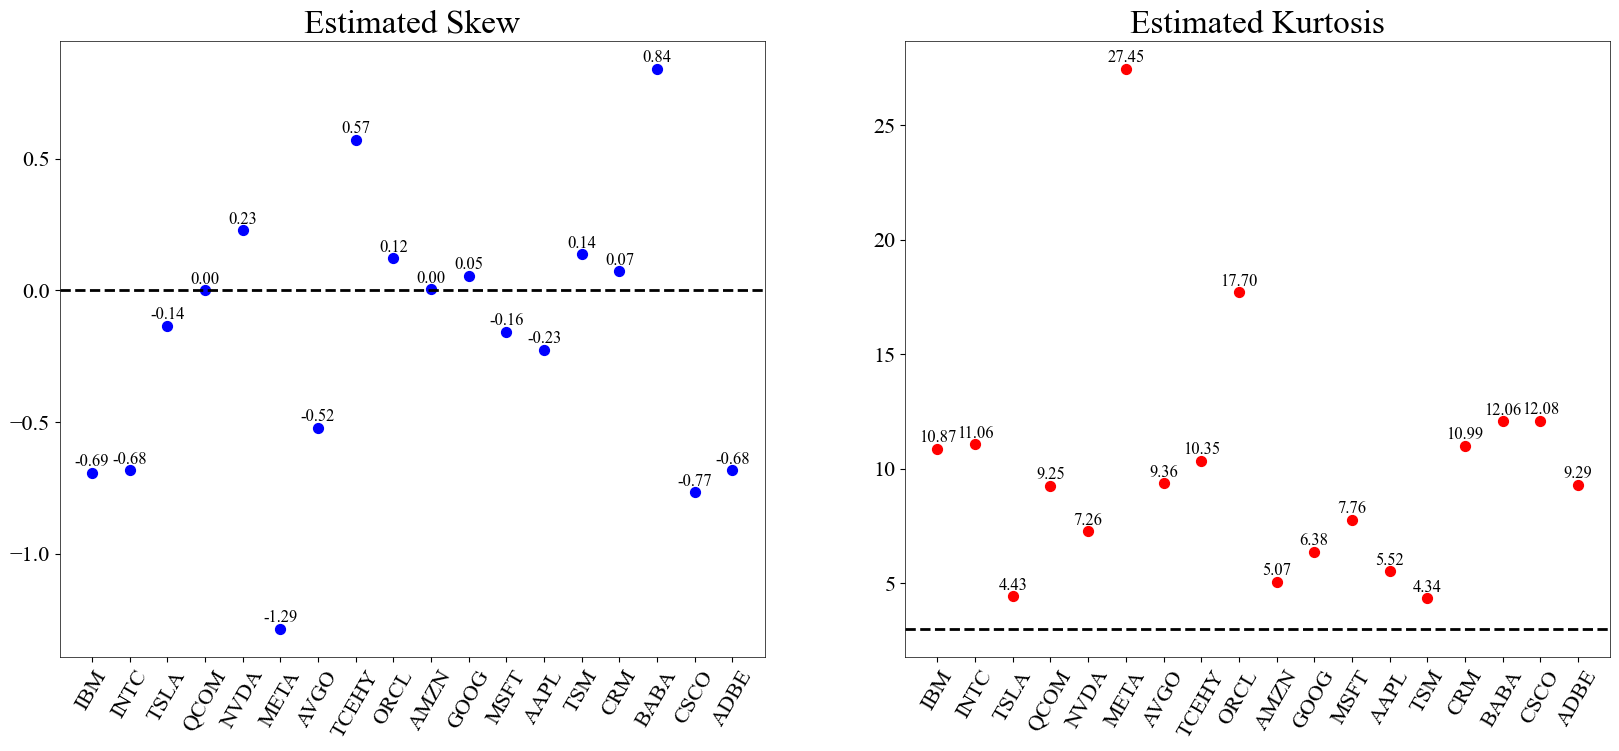

In [218]:
skew, kurt = np.zeros(n), np.zeros(n)
for k in range(n):
    tk = TICKERS[k]
    returns = simple_returns[tk][1].dropna()
    skew[k] = scipy.stats.skew(returns, bias=False)
    kurt[k] = scipy.stats.kurtosis(returns, bias=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot skewness
ax[0].scatter(TICKERS, skew, s=50, color="blue")
ax[0].set_xticklabels(labels=TICKERS, rotation=60)
ax[0].set_title("Estimated Skew", fontsize=24)
ax[0].axhline(y=0.0, linestyle="--", lw=2.0, color='black')

# Annotate skewness values
for i in range(n):
    ax[0].annotate(f'{skew[i]:.2f}', (TICKERS[i], skew[i]), textcoords="offset points", xytext=(0,5), ha='center',
                   fontsize=12)

# Plot kurtosis
ax[1].scatter(TICKERS, kurt, s=50, color='red')
ax[1].set_xticklabels(labels=TICKERS, rotation=60)
ax[1].set_title("Estimated Kurtosis", fontsize=24)
ax[1].axhline(y=3.0, linestyle="--", lw=2.0, color='black')

# Annotate kurtosis values
for i in range(n):
    ax[1].annotate(f'{kurt[i]:.2f}', (TICKERS[i], kurt[i]), 
                   textcoords="offset points", xytext=(0,5), ha='center', 
                   fontsize=12)

plt.show()
# save plot
fig.savefig("./img/skew_kurt.png", dpi=200, bbox_inches='tight');

In this note, we have crudely demonstrated that the return series are generally non-normal and fat-tailed.

Finally, we fit normal and assymetric Laplace distributions to the log return data

In [294]:
# first fit for META
meta_laplace_fit = scipy.stats.fit(
    scipy.stats.laplace_asymmetric, simple_returns["META"][1].dropna(), 
    bounds={
        "kappa": [-10., 10.],
        "loc": [-10., 10.], 
        "scale": [0.0, 1.0]
    }
)
meta_gaussian_fit = scipy.stats.fit(
    scipy.stats.norm, simple_returns["META"][1].dropna(), 
    bounds={
        "loc": [-10., 10.],
        "scale": [0.0, 1.0]
    }
)

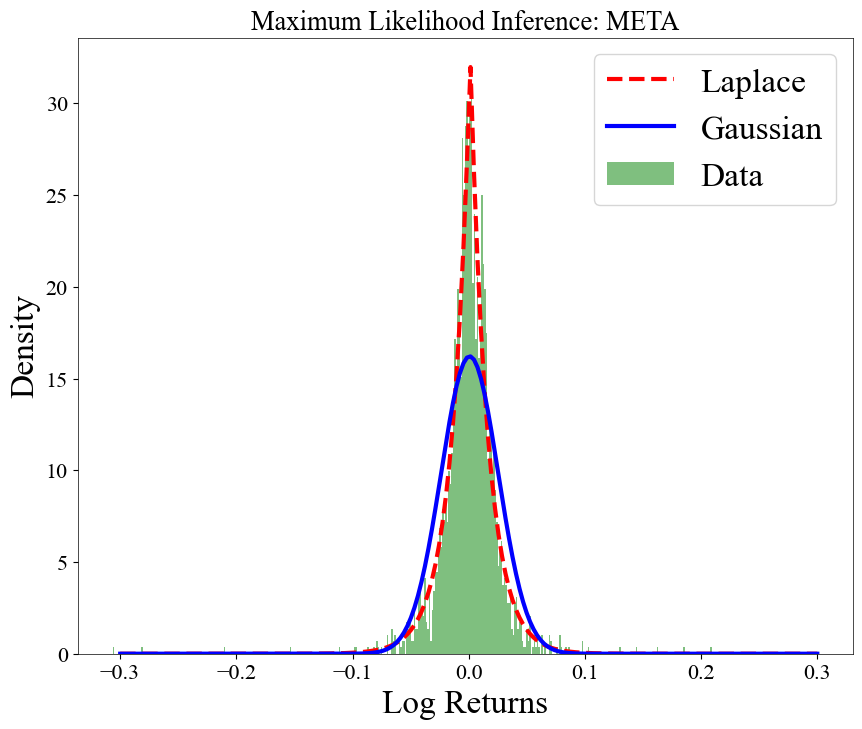

In [297]:
meta_range = np.linspace(-0.3, 0.3, 200);
fig = plt.figure(1, figsize=(10, 8));

plt.plot(meta_range, 
         scipy.stats.laplace_asymmetric(kappa=meta_laplace_fit.params.kappa, 
                                        loc=meta_laplace_fit.params.loc, 
                                        scale=meta_laplace_fit.params.scale).pdf(meta_range),
        color="red", linestyle="--", lw=3.0, label="Laplace");
plt.plot(meta_range, 
        scipy.stats.norm(loc=meta_gaussian_fit.params.loc, 
                        scale=meta_gaussian_fit.params.scale).pdf(meta_range), 
        color="blue", linestyle="-", lw=3.0, label="Gaussian");
plt.hist(simple_returns["META"][1].dropna(), bins=400, density=True, color="green", alpha=0.5, label="Data");
plt.legend(fontsize=24);
plt.xlabel("Log Returns", fontsize=24);
plt.ylabel("Density", fontsize=24);
plt.title("Maximum Likelihood Inference: META");
plt.show()
# save plot
fig.savefig("./img/meta_mle.png", dpi=200, bbox_inches='tight');